# Trying a multi objective optimization for Aesthetics and Prompt Fulfillment (CLIP-Score) exploring the prompt embedding latent space

In [15]:
from evolutionary.plotting import plot_fitness_statistics
from model_helpers.auto_pipeline import auto_diffusion_pipeline
from diffusers.utils import logging
from evolutionary.image_processing import create_animation_from_generations, create_generation_image_grid, save_images_from_generation

In [16]:
logging.disable_progress_bar() # Or else your output will be full of progress bars
logging.set_verbosity_error() # Enable again if you are having problems

# Factory for loading the DiffusionPipeline from the HuggingFace Hub
def setup_pipeline():
    pipe = auto_diffusion_pipeline("stabilityai/sdxl-turbo") # This has to be compatible with the ImageCreator
    pipe.set_progress_bar_config(disable=True)
    return pipe

In [17]:
from evolutionary.prompt_encoding.image_creation import SDXLPromptEmbeddingImageCreator
from evolutionary.prompt_encoding.variation import PooledArithmeticCrossover, PooledUniformGaussianMutator, UniformGaussianMutatorArguments
from evolutionary.selectors import TournamentSelector
from evolutionary.algorithms.nsga_ii import NSGA_II
from evolutionary.image_evaluators import AestheticsImageEvaluator, CLIPScoreEvaluator 
from evolutionary.evolution_base import MultiObjectiveEvaluator

prompt = "a cat sitting on a lamp in austria"
population_size = 100
num_generations = 100
batch_size = 1
elitism = 1

# Create the necessary components for the genetic algorithm
creator = SDXLPromptEmbeddingImageCreator(pipeline_factory=setup_pipeline, batch_size=batch_size, inference_steps=3)
evaluator = MultiObjectiveEvaluator([AestheticsImageEvaluator(), CLIPScoreEvaluator(prompt=prompt)])
crossover = PooledArithmeticCrossover(crossover_rate=0.5, crossover_rate_pooled=0.5)
# clamp_range was evaluated with pre-testing/clamp_range/sdxl_turbo.py
mutation_arguments = UniformGaussianMutatorArguments(mutation_rate=0.1, mutation_strength=2.5, clamp_range=(-900, 900)) 
mutation_arguments_pooled = UniformGaussianMutatorArguments(mutation_rate=0.1, mutation_strength=0.5, clamp_range=(-8, 8))
mutator = PooledUniformGaussianMutator(mutation_arguments, mutation_arguments_pooled)
selector = TournamentSelector(tournament_size=3)

# Prepare initial arguments
init_embed = creator.arguments_from_prompt(prompt)
init_args = [init_embed for _ in range(population_size)]

nsga = NSGA_II(
    num_generations=num_generations,
    population_size=population_size,
    solution_creator=creator,
    selector=selector,
    crossover=crossover,
    mutator=mutator,
    evaluator=evaluator,
    elitism_count=elitism,
    initial_arguments=init_args,
    post_evaluation_callback=lambda g, a: save_images_from_generation(a.population, g)  # TODO only best image save?
)

Loaded StableDiffusionXLPipeline {
  "_class_name": "StableDiffusionXLPipeline",
  "_diffusers_version": "0.25.0",
  "_name_or_path": "stabilityai/sdxl-turbo",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "EulerAncestralDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

Model loaded successfully.


In [18]:
best_solution = nsga.run()

Generation 0 started.
Generation 1 started.
Generation 2 started.
Generation 3 started.
Generation 4 started.
Generation 5 started.
Generation 6 started.
Generation 7 started.
Generation 8 started.
Generation 9 started.
Generation 10 started.
Generation 11 started.
Generation 12 started.
Generation 13 started.
Generation 14 started.
Generation 15 started.
Generation 16 started.
Generation 17 started.
Generation 18 started.
Generation 19 started.
Generation 20 started.
Generation 21 started.
Generation 22 started.
Generation 23 started.
Generation 24 started.
Generation 25 started.
Generation 26 started.
Generation 27 started.
Generation 28 started.
Generation 29 started.
Generation 30 started.
Generation 31 started.
Generation 32 started.
Generation 33 started.
Generation 34 started.
Generation 35 started.
Generation 36 started.
Generation 37 started.
Generation 38 started.
Generation 39 started.
Generation 40 started.
Generation 41 started.
Generation 42 started.
Generation 43 started

[7.536618232727051, 29.014434814453125]


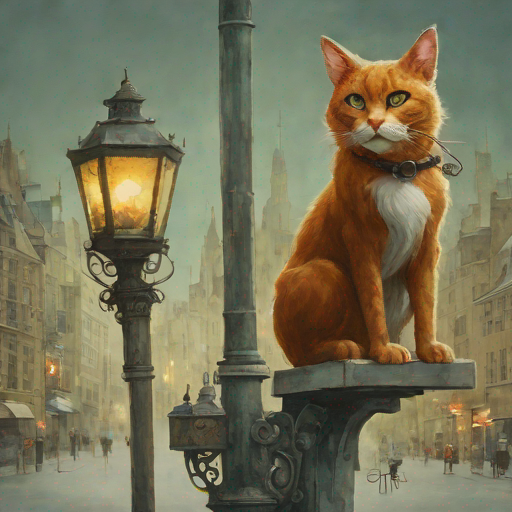

In [20]:
from diffusers.utils import make_image_grid

# Show best solution
print(best_solution.fitness)
make_image_grid(best_solution.result.images, 1, batch_size)

## Visualize the evolution

In [ ]:
for gen in range(num_generations):
    create_generation_image_grid(gen, max_images=10)

In [ ]:
video_loc = create_animation_from_generations(num_generations)
print(video_loc)
from IPython.display import Video
Video(filename=video_loc) # This does not work for all browsers/notebooks, set embed to true when you want to include it in the notebook (warning large file size)

## Plot fitness statistics

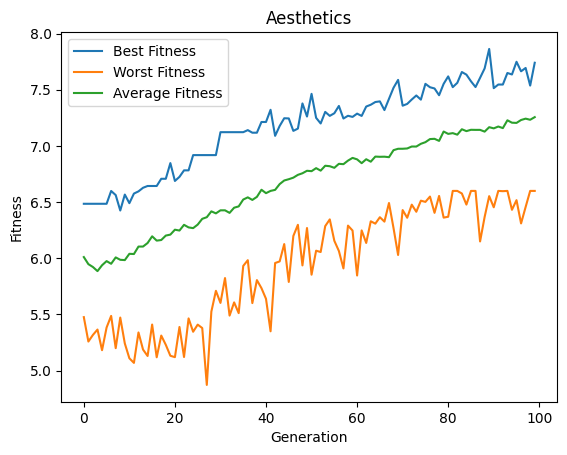

In [41]:
plot_fitness_statistics(num_generations, nsga.best_fitness, nsga.worst_fitness, nsga.avg_fitness, title="Aesthetics", multi_objective_plot_index=0)

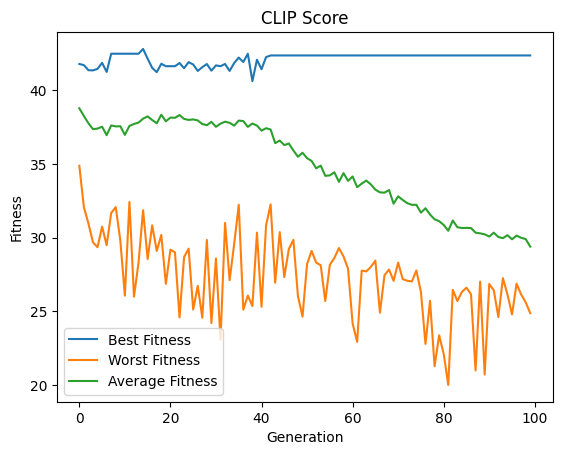

In [42]:
plot_fitness_statistics(num_generations, nsga.best_fitness, nsga.worst_fitness, nsga.avg_fitness, title="CLIP Score", multi_objective_plot_index=1)

## Save notebook and components

In [ ]:
!jupyter nbconvert --to html nsga_notebook.ipynb

### Save the run to disk

In [ ]:
import pickle
import os
from datetime import datetime

os.makedirs("saved_runs", exist_ok=True)
with open(os.path.join("saved_runs", f"nsga_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.pkl"), "wb") as f:
    pickle.dump(nsga, f)

## Fallback functions for when something went wrong

### Access Best Solution from Disk

In [ ]:
import os
import glob
import evolutionary.image_processing as ip
from PIL import Image

num_generations = 42  # Set this to the number of generations you ran (if you didn't finish)
generation_dir = os.path.join("results", f"{num_generations}")
image_files = glob.glob(os.path.join(generation_dir, "*.png"))
image_files.sort(key=ip.parse_fitness_from_filename, reverse=True)
print(image_files[0])
Image.open(image_files[0])
print(best_solution.fitness)
best_solution.result.images[0]

### ffmpeg is not installed, create GIF instead

In [ ]:
from evolutionary.image_processing import create_animation_from_generations_pil
video_loc = create_animation_from_generations_pil(num_generations)
print(video_loc)
from IPython.display import Video
Video(filename=video_loc) 